## Example notebook to download CARRA data

In [1]:
import metview as mv

import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature#
import cdsapi
# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()
import os



### Using Copernicus python API to download the data.
### Set the CDS_API_KEY in your system and export it

```
export CDS_API_KEY=your_key
```


In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = os.getenv("CDS_API_KEY")
KEY = os.getenv("CDS_UID")
c = cdsapi.Client()
DATADIR = './'

# Selecting lat and lon for a particular domain
# Format is lat, lon, lat, lon for upper and lower corner.
# This is used to fetch ERA5 data
area_europe = [72, -25, 34,40]
area_greenland = [85,-75,60,-10]
years = ["2020","2021","2022"]
variable = "2m_temperature"
DATADIR = './'


In [3]:
## Example monthly means from 

In [4]:
out_cds=f'{DATADIR}era5_monthly_t2m_greenland.nc'
if not os.path.isfile(out_cds):
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'product_type': 'monthly_averaged_reanalysis',
            'variable': '2m_temperature',
            'year': years,
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'time': '00:00',
            'area': area_greenland,
            'format': 'netcdf',
        },
        out_cds)
else:
    print(f"{out_cds} already downloaded")


./era5_monthly_t2m_greenland.nc already downloaded


## Checking the contents

In [5]:
ds = xr.open_dataset(out_cds)
ds


<xarray.Dataset>
Dimensions:    (longitude: 261, latitude: 101, expver: 2, time: 5)
Coordinates:
  * longitude  (longitude) float32 -75.0 -74.75 -74.5 ... -10.5 -10.25 -10.0
  * latitude   (latitude) float32 85.0 84.75 84.5 84.25 ... 60.5 60.25 60.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2023-05-01
Data variables:
    t2m        (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-27 14:38:43 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
ds.longitude

<xarray.DataArray 'longitude' (longitude: 261)>
array([-75.  , -74.75, -74.5 , ..., -10.5 , -10.25, -10.  ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -75.0 -74.75 -74.5 ... -10.5 -10.25 -10.0
Attributes:
    units:      degrees_east
    long_name:  longitude

## Plot them without the map

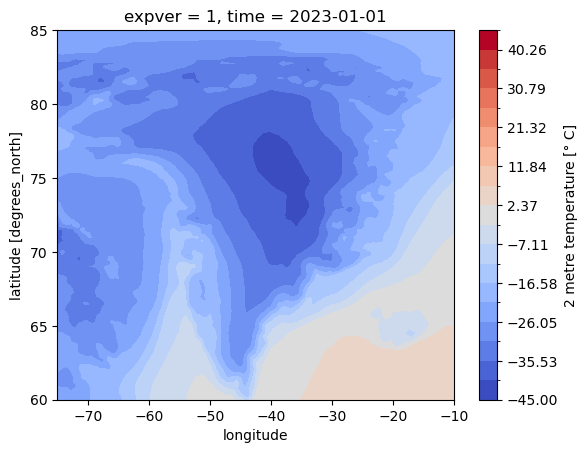

In [7]:
ds_180 = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')
# Create Xarray Data Array
da = ds_180['t2m']
# Create Xarray Data Array
da_degc = ds['t2m'] - 273.15
da_degc = da - 273.15
da_degc = da_degc.assign_attrs(da.attrs)
da_degc.attrs['units'] = '° C'
import matplotlib as mpl
cmap = mpl.cm.coolwarm
#cmap = mpl.cm.RdBu_r
levels=np.linspace(-45,45,20)

da_degc[0,0,:,:].plot.contourf(cmap=cmap,levels=levels)


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_colorMaps(cmap):

    fig, ax = plt.subplots(figsize=(4,0.4))
    col_map = plt.get_cmap(cmap)
    mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')

    plt.show()

# for cmap_id in plt.colormaps():
#     print(cmap_id)
#     plot_colorMaps(cmap_id)

## get CARRA data, in this case in grib2 format

In [9]:
fin_carra=os.path.join(DATADIR,"means_gribmean","t2m_mean.grib2")

carra = mv.read(fin_carra)
ds_carra = carra.to_dataset()
ds_carra

<xarray.Dataset>
Dimensions:            (y: 1269, x: 1069)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    t2m                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2023-07-26T10:01 GRIB to CDM+CF via cfgrib-0.9.1...

In [64]:
#test with grib engine. Same result
import pygrib
ds=xr.open_dataset(fin_carra, engine='cfgrib', filter_by_keys={'typeOfLevel': 'heightAboveGround', 'topLevel':2})

In [65]:
ds

<xarray.Dataset>
Dimensions:            (y: 1269, x: 1069)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    t2m                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             enmi
    GRIB_centreDescription:  Oslo
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Oslo
    history:                 2023-07-12T17:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [30]:
nx = ds_carra.dims["x"]
ny = ds_carra.dims["y"]
lats=ds_carra["latitude"]#.reshape((nx,ny))
ds_carra.coords["latitude"]

<xarray.DataArray 'latitude' (y: 1269, x: 1069)>
[1356561 values with dtype=float64]
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude

In [42]:
df_carra=ds_carra.to_dataframe()

In [88]:
lats=df_carra["latitude"].values
lons=df_carra["longitude"].values

In [62]:
lats

array([55.81      , 55.8174602 , 55.82490826, ..., 77.86645179,
       77.8454289 , 77.82440048])

In [50]:
ds_carra.coords

Coordinates:
    time               datetime64[ns] 2023-01-01
    step               timedelta64[ns] 00:00:00
    heightAboveGround  float64 2.0
    latitude           (y, x) float64 55.81 55.82 55.82 ... 77.87 77.85 77.82
    longitude          (y, x) float64 302.9 302.9 303.0 ... 37.66 37.7 37.73
    valid_time         datetime64[ns] 2023-01-01

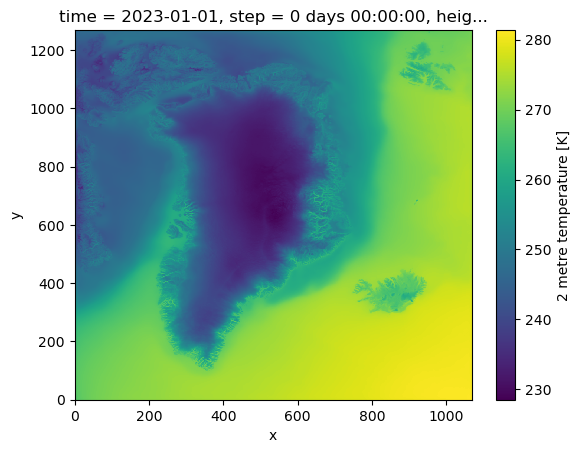

In [71]:
#ds_carra["t2m"].plot.imshow(x=lats,y=lons)#x="longitude",y="latitude")  #contourf#x=ds_carra.coords["longitude"],y=ds_carra.coords["latitude"])


ds_carra["t2m"].plot() #.imshow(extent=[lons.min(), lons.max(), lats.min(),lats.max()])

In [94]:
import copy
import pygrib
import numpy.ma as ma
import datetime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def read_vars(gribfile,params):
    '''
    Reads a file that contains only one time step
    '''
    print("in read_vars")
    ds = {}
    vars = copy.deepcopy(params)
    f = pygrib.open(gribfile)
    was_found=False
    for msg in f:
        for param in vars:
            if vars[param]['param']== str(msg['param']) and vars[param]["level"]==msg["level"] and vars[param]["typeOfLevel"]==msg['typeOfLevel'] and vars[param]["levelType"]==msg["levelType"]:
                print(f'found {vars[param]}')
                vars[param]['msg'] = msg
                was_found=True
        if not was_found:
            #quick check for when it doesnt find anything
            for param in vars:
                print(vars[param]['param'])
                if vars[param]['param']== str(msg['param']):
                    print(f"{param} not found. Printing some info")
                    this_param=msg["param"]
                    this_level=msg["level"]
                    this_tlevel=msg['typeOfLevel']
                    this_ltype=msg["levelType"]
                    print("level :{this_level}")
                    print("typeOfLevel {this_tlevel}")
                    print("levelType {this_ltype}")
                    print("Original params:")
                    print(params)
                    for key in ["param","level","typeOfLevel","levelType"]:
                        new_params = {param:{"param":this_param,"level":this_level,
                                             "typeOfLevel":this_tlevel,"levelType":this_ltype}}
                    print(new_params)
                    sys.exit(0)

    for param in vars:
        msghit = vars[param]['msg']
        nx = msghit['Nx']
        ny = msghit['Ny']
        date = msghit['date']
        hour = msghit['hour']
        fcstep = msghit['step']
        lons = msghit['longitudes'].reshape((ny,nx))
        lats = msghit['latitudes'].reshape((ny,nx))
        lat0 = msghit['LaDInDegrees']
        lon0 = msghit['LoVInDegrees']
        lat1 = msghit['Latin1InDegrees']
        lat2 = msghit['Latin2InDegrees']
        val = ma.masked_values(msghit['values'].reshape((ny,nx)),msghit['missingValue'])
        name = msghit['parameterName']
        vars[param]['field'] = val
        dt = datetime.datetime.strptime(str(date)+str(hour),"%Y%m%d%H")
        lons2 = np.where(lons>180,lons-360,lons)
        lon0 = np.where(lon0>180,lon0-360,lon0)
        proj = ccrs.LambertConformal(central_latitude=lat0,
                                 central_longitude=lon0,
                                 standard_parallels=(lat1, lat2))
        ds['misc'] = {'date':dt,
                      'lons':lons2,
                      'lats':lats,
                      'proj':proj,
                      'fcstep':fcstep}
        ds['params'] = vars

    return ds

In [95]:
params = {'t2m':{"param":"167","level":2,"typeOfLevel":"heightAboveGround","levelType":"sfc"}}
fin_carra=os.path.join(DATADIR,"means_gribmean","t2m_mean.grib2")

ds_read = read_vars(fin_carra,params)
proj = ds_read["misc"]["proj"]
print(proj)

in read_vars
found {'param': '167', 'level': 2, 'typeOfLevel': 'heightAboveGround', 'levelType': 'sfc'}
+proj=lcc +ellps=WGS84 +lon_0=-36.0 +lat_0=72.0 +x_0=0.0 +y_0=0.0 +lat_1=72.0 +lat_2=72.0 +no_defs +type=crs


Using t2m to plot temperature


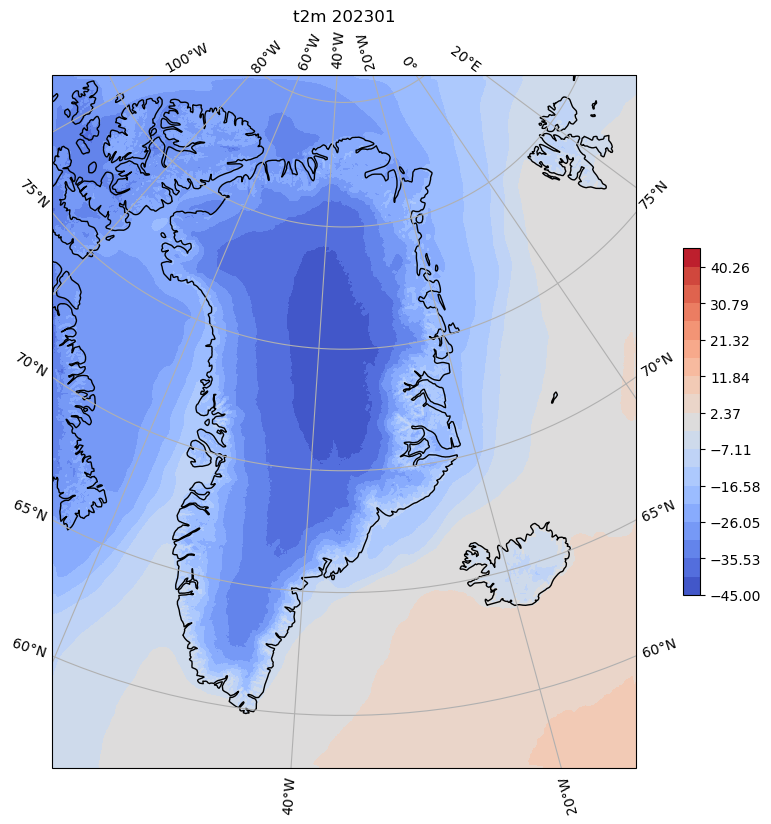

In [105]:
import matplotlib.ticker as mticker

def plot_t2m(ifile,params,suf_png):
    '''
     Plot t2m and wind velocity
    '''
    print(f"Plotting {params} for {ifile}")
    ds = read_vars(ifile,params)
    fig=t2m(ds)
    print(f"Saving plot to {suf_png}")
    plt.savefig(suf_png)
    fig.clf()
    plt.close(fig)
    gc.collect()

def t2m(ds,cmap,levels):
    lons = ds['misc']['lons']
    lats = ds['misc']['lats']
    proj = ds['misc']['proj']
    dt = ds['misc']['date']
    fcstep = ds['misc']['fcstep']

    # Plotting parameters
    t_colors = ['#ffffff','#e6e6e6','#cccccc','#b3b3b3','#ae99ae','#7a667a','#330066','#590080','#8000ff',
                '#0080ff','#00ccff','#00ffff','#26e699','#66bf26','#bfe626','#ffff80','#ffff00','#ffda00',
                '#ffb000','#ff7300','#ff0000','#cc0000','#80002c','#cc3d6e','#ff00ff','#ff80ff','#ffbfff',
                '#e6cce6','#e6e6e6']
    t_levels = np.array([-80,-70,-60,-52,-48,-44,-40,-36,-32,-28,-24,-20,-16,-12,-8,-4,0,
                4,8,12,16,20,24,28,32,36,40,44,48,52,56])
    variable = [key for key in ds["params"].keys()][0]
    print(f"Using {variable} to plot temperature")
    # Fields to plot
    #t2m = ds['params']['t2m']['field'] - 273.15
    t2m = ds['params'][variable]['field'] - 273.15
    #print(t2m)
    fig = plt.figure(figsize=[12,9])
    ax = plt.axes(projection=proj)

    CS = ax.contourf(lons,lats,t2m,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels)#,colors=t_colors,levels=t_levels)
    plt.colorbar(CS,shrink=0.5,orientation='vertical')

    ax.coastlines('50m')
    #ax.gridlines()
    #this draws the labels
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    #ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())#np.arange(-180,181,60), crs=ccrs.PlateCarree())
    ax.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    ax.xlabel_style = {'size': 15, 'color': 'gray'}

    ax.xformatter = LONGITUDE_FORMATTER

    #plt.title("T2M \n%s UTC + %dh" % (dt.strftime('%Y-%m-%d %H:00'), fcstep))
    period=dt.strftime('%Y%m')
    plt.title(f"{variable} {period}")
    
    return fig
levels=np.linspace(-45,45,20)
fig=t2m(ds_read,cmap,levels)    
plt.show()

In [89]:
#t2m = ds_carra["t2m"].values.reshape((nx,ny))
#longitudes = lons.reshape((ny,nx))
#latitudes = lats.reshape((ny,nx))

In [90]:
#longitudes

In [99]:
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import cartopy.feature as cfeature
#import cartopy.crs as ccrs
#import matplotlib.pyplot as plt

#lat1=72.0
#lat2=72
#proj = ccrs.LambertConformal(central_latitude=72.0,
#                                 central_longitude=-36.0,
#                                 standard_parallels=(lat1, lat2))
#fig = plt.figure(figsize=[12,9])
#ax = plt.axes(projection=proj)
#t2m=ds_carra["t2m"].reshape((ny,nx))
#ax.contourf(lons,lats,t2m)#,transform=ccrs.PlateCarree(),cmap=cmap,levels=levels)#

In [201]:
#lats["latitude"]
nx = 
lats=
lons=test["longitude"].values